(cap-inf-one-mean)=
# Inferenza su una media

Esaminiamo ora in maggiore dettaglio un caso che abbiamo anticipato in precedenza, ovvero quello in cui disponiamo di un campione di dati a livello di scala a intervalli o rapporti e vogliamo fare inferenza sulla media della popolazione da cui il campione è stato estratto.

## Caso Normale-Normale con varianza nota

Supponiamo che i dati $y$ siano un campione casuale estratto da una popolazione che segue la legge Normale. Ciò significa che le osservazioni possono essere considerate come una sequenza di variabili casuali indipendenti e identicamente distribuite. Supponiamo che ciascuna v.c. segua la distribuzione Normale. Abbiamo dunque

$$
Y_1, \dots, Y_n  \stackrel{iid}{\sim} \mathcal{N}(\mu, \sigma).
$$

In precedenza abbiamo visto come, in tali circostanze, la verosimiglianza $p(y \mid \mu, \sigma)$ sia Normale. Per fare inferenza sul parametro $\mu$, facciamo due assunzioni: consideriamo $\sigma$ nota e imponiamo su $\mu$ una distribuzione a priori Normale. Questa situazione definisce lo schema coniugato Normale-Normale. Il caso Normale-Normale consente una derivazione analitica della distribuzione a posteriori $p(\mu \mid y)$ (così come nel caso beta-binomiale era possibile una derivazione analitica della distribuzione a posteriori $p(\theta \mid y)$).

La trattazione matematica di una tale derivazione è piuttosto complessa e qui verrà solo accennata. Nel seguito, impareremo invece ad applicare la soluzione che viene ottenuta in tali circostanze; mostreremo inoltre come fare inferenza su $\mu$ mediante i metodi MCMC.

## Derivazione analitica della distribuzione a posteriori $p(\mu \mid y)$

Per $\sigma^2$ nota, la famiglia della distribuzione Normale è coniugata a sé stessa: se la funzione di verosimiglianza è Normale, la scelta di una distribuzione a priori Normale per $\mu$ assicura che anche la distribuzione a posteriori $p(\mu \mid y)$ sia Normale.

Poniamoci dunque il problema di trovare $p(\mu \mid y)$ nel caso di un campione casuale $Y_1, \dots, Y_n \stackrel{iid}{\sim} \mathcal{N}(\mu, \sigma)$, supponendo $\sigma$ perfettamente nota e imponendo su $\mu$ una distribuzione a priori Normale. Ricordiamo che la densità gaussiana è

$$
p(y_i \mid \mu, \sigma) = \frac{1}{{\sigma \sqrt {2\pi}}}\exp\left\{{-\frac{(y_i - \mu)^2}{2\sigma^2}}\right\}.
$$

Essendo le variabili i.i.d., possiamo scrivere la densità congiunta come il prodotto delle singole densità e quindi si ottiene

$$
p(y \mid \mu) = \, \prod_{i=1}^n p(y_i \mid \mu).
$$

Una volta osservati i dati $y$, la verosimiglianza diventa

$$
\begin{align}
p(y \mid \mu) =& \, \prod_{i=1}^n p(y_i \mid \mu) = \notag\\
& \frac{1}{{\sigma \sqrt {2\pi}}}\exp\left\{{-\frac{(y_1 - \mu)^2}{2\sigma^2}}\right\} \times \notag\\
 & \frac{1}{{\sigma \sqrt {2\pi}}}\exp\left\{{-\frac{(y_2 - \mu)^2}{2\sigma^2}}\right\} \times  \notag\\
& \vdots \notag\\
 & \frac{1}{{\sigma \sqrt {2\pi}}}\exp\left\{{-\frac{(y_n - \mu)^2}{2\sigma^2}}\right\}.
\end{align}
$$

Se la densità a priori $p(\mu)$ è gaussiana, allora anche la densità a posteriori $p(\mu \mid y)$ sarà gaussiana. Poniamo

$$
p(\mu) = \frac{1}{{\tau_0 \sqrt {2\pi}}}\exp\left\{{-\frac{(\mu - \mu_0)^2}{2\tau_0^2}}\right\},
$$ 

ovvero imponiamo a $\mu$ una distribuzione a priori gaussiana con media $\mu_0$ e varianza $\tau_0^2$. Ciò significa dire che, a priori, $\mu_0$ rappresenta il valore più verosimile per $\mu$, mentre $\tau_0^2$ quantifica il grado della nostra incertezza rispetto a tale valore.

Svolgendo una serie di passaggi algebrici, si arriva alla distribuzione a posteriori

$$
p(\mu \mid y) = \frac{1}{{\tau_p \sqrt {2\pi}}}\exp\left\{{-\frac{(\mu - \mu_p)^2}{2\tau_p^2}}\right\},
$$ 

dove

$$
\mu_p = \frac{\frac{1}{\tau_0^2}\mu_0+ \frac{n}{\sigma^2}\bar{y}}{\frac {1}{\tau_0^2} + \frac{n}{\sigma^2}} 
$$

e

$$
\tau_p^2 = \frac{1}{\frac {1}{\tau_0^2}+ \frac{n}{\sigma^2}}.
$$ 

Ciò significa che, se la distribuzione a priori $p(\mu)$ è gaussiana, allora anche la distribuzione a posteriori $p(\mu \mid y)$ sarà gaussiana con valore atteso $\mu_p$ e varianza $\tau_p^2$ date dalle espressioni precedenti.

In conclusione, il risultato trovato indica che:

-   il valore atteso a posteriori è una media pesata fra il valore atteso a priori $\mu_0$ e la media campionaria $\bar{y}$; il peso della media campionaria è tanto maggiore tanto più è grande $n$ (il numero di osservazioni) e $\tau_0^2$ (l'incertezza iniziale);
-   l'incertezza (varianza) a posteriori $\tau_p^2$ è sempre più piccola dell'incertezza a priori $\tau_0^2$ e diminuisce al crescere di $n$.

In [25]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy.stats import beta
from scipy.stats import norm
import statistics
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
plt.style.use('tableau-colorblind10')
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.0.0


Per esaminare un esempio pratico, consideriamo i 30 valori BDI-II dei soggetti clinici di {cite}`zetsche_2019future`.

In [26]:
y = [26.0, 35.0, 30, 25, 44, 30, 33, 43, 22, 43,
    24, 19, 39, 31, 25, 28, 35, 30, 26, 31, 41,
    36, 26, 35, 33, 28, 27, 34, 27, 22]

Supponiamo che la varianza $\sigma^2$ della popolazione sia identica alla varianza del campione:

In [27]:
sigma = np.std(y)
sigma

6.495810615739622

Per fare un esempio, imponiamo su $\mu$ una distribuzione a priori $\mathcal{N}(25, 2)$. In tali circostanze, la distribuzione a posteriori del parametro $\mu$ può essere determinata per via analitica e corrisponde ad una Normale di media e varianza definite dall'eq. {eq}`eq-post-norm-mup` e dall'eq. {eq}`eq-post-norm-taup2`. La figura seguente mostra un grafico della distribuzione a priori, della verosimiglianza e della distribuzione a posteriori di $\mu$.

In [28]:
def gaussian(y, m, s):
    l = np.prod(norm.pdf(y, loc=m, scale=s))
    return l

In [29]:
x_axis = np.arange(18, 38, 0.01)
s = np.std(y)
like = [gaussian(y, val, s) for val in x_axis] 
l = like / np.sum(like)*100

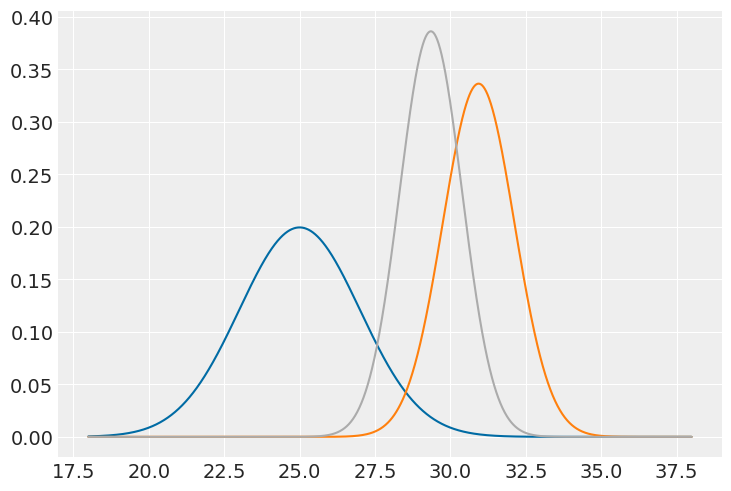

In [30]:
plt.plot(x_axis, norm.pdf(x_axis, 25, 2))
plt.plot(x_axis, l)
plt.plot(x_axis, norm.pdf(x_axis, 29.35073, 1.032919))
plt.show()

Verifichiamo i risultati ottenuti sopra applicando l'eq. {eq}`eq-post-norm-mup` e l'eq. {eq}`eq-post-norm-taup2`. Definiamo una funzione che ritorna la media della distribuzione a posteriori di $\mu$.

In [31]:
def mu_post(tau_0, mu_0, sigma, ybar, n):
    return (1/tau_0**2 * mu_0 + n/sigma**2 * ybar) / (1/tau_0**2 + n/sigma**2)

Troviamo la media a posteriori.

In [32]:
mu_0 = 25  # media della distribuzione a priori per mu
tau_0 = 2  # sd della distribuzione a priori per mu
sigma = np.std(y) # sd del campione (assunta essere sigma)
ybar = np.mean(y) # media del campione
n = len(y)

mu_post(tau_0, mu_0, sigma, ybar, n) 

29.389762700717927

Definiamo una funzione che ritorna la deviazione standard della distribuzione a posteriori di $\mu$.

In [33]:
def tau_post(tau_0, sigma, n):
    return np.sqrt(1 / (1/tau_0**2 + n/sigma**2))

Troviamo la deviazione standard a posteriori.

In [34]:
tau_0 = 2  # sd della distribuzione a priori per mu
sigma = np.std(y) # sd del campione (assunta essere sigma)
n = len(y)

tau_post(tau_0, sigma, n) 

1.0201026493673773

## Il modello Normale con PyMC

I priori coniugati Normali di una Normale non richiedono l'approssimazione numerica ottenuta mediante metodi MCMC. Tuttavia, per fare un esercizio e per verificare che i risultati con MCMC corrispondano a quelli trovati per via analitica, ripetiamo l'esercizio precedente usando PyMC.

### Versione 1 ($\sigma$ nota)

Come in precedenza, impongo su $\mu$ una distribuzione a priori $\mathcal{N}(25, 2)$ e considero noto il parametro $\sigma = 6.606858$. Il modello dunque diventa il seguente.

$$
\begin{align}
Y_i &\sim \mathcal{N}(\mu, \sigma) \notag\\
\mu &\sim \mathcal{N}(25, 2) \notag\\
\sigma &= 6.606858 \notag
\end{align}
$$

In base al modello definito sopra, la variabile casuale $Y$ segue la distribuzione Normale di parametri $\mu$ e $\sigma$. Il parametro $\mu$ è sconosciuto e abbiamo deciso di descrivere la nostra incertezza relativa ad esso mediante una distribuzione a priori Normale di media 25 e deviazione standard 2. Il parametro $\sigma$ è invece assunto essere noto e uguale a 6.606858. Usando PyMC specifico il modello come segue.

In [35]:
gauss_model = pm.Model()

with gauss_model:

    # Priors 
    mu = pm.Normal("mu", mu=25, sigma=2)
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=6.606858, observed=y)

Eseguo il campionamento MCMC.


In [36]:
with gauss_model:
    # draw 1000 posterior samples
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


Una sintesi della distribuzione a posteriori dei parametri si ottiene nel modo seguente.

In [37]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,29.35,1.04,27.42,31.36,0.03,0.02,1696.62,2727.14,1.0


Si noti che le stime ottenute corrispondono ai valori teorici attesi, ovvero $\mu_p$ = 29.39 contro un valore teorico di 29.3898 e $\tau_p$ = 1.03 contro un valore teorico di 1.0201.

Descriviamo la traccia (cioè il vettore dei campioni del parametro $\mu$ prodotti dalla procedura di campionamento MCMC) mediante un *trace plot* .

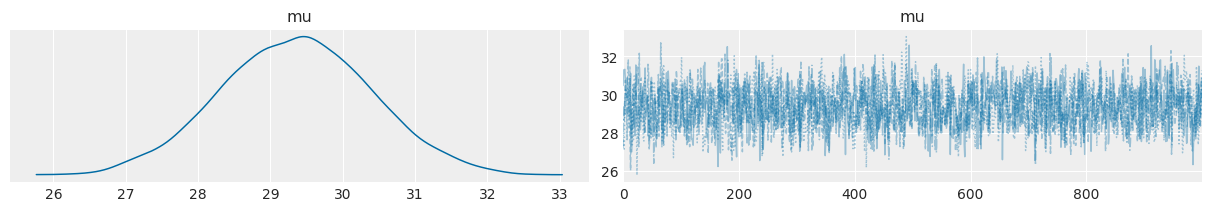

In [38]:
az.plot_trace(idata, combined=True)
plt.show()

Trovo l'intervallo di credibilità a più alta densità a posteriori (HPD) al 95%.


In [39]:
az.hdi(idata, hdi_prob=0.95)


<xarray.Dataset>
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 'lower' 'higher'
Data variables:
    mu       (hdi) float64 27.32 31.41

Le stime così trovate sono molto simili ai quantili di ordine 0.025 e 0.975 della distribuzione a posteriori di $\mu$ ottenuta per via analitica.

In [40]:
norm.ppf([0.025, 0.975], loc=29.35073, scale=1.032919)

array([27.32624596, 31.37521404])


### Versione 2 ($\sigma$ incognita)

È facile estendere il caso precedente alla situazione in cui il parametro $\sigma$ è incognito. Se non conosciamo $\sigma$, è necessario imporre su tale parametro una distribuzione a priori. Supponiamo di ipotizzare per $\sigma$ una distribuzione a priori $Cauchy(0, 15)$.

Mediante una $Cauchy(0, 15)$ descrivo il grado di plausibilità soggettiva che attribuisco ai possibili valori (\> 0) del parametro $\sigma$. Ai valori prossimi allo 0 attribuisco la plausibilità maggiore; la plausibilità dei possibili valori $\sigma$ diminuisce progressivamente quando ci si allontana dallo 0, come indicato dalla curva della figura seguente. Ritengo poco plausibili valori $\sigma$ maggiori di 40, anche se non escludo completamente che $\sigma$ possa assumere un valore di questo tipo.

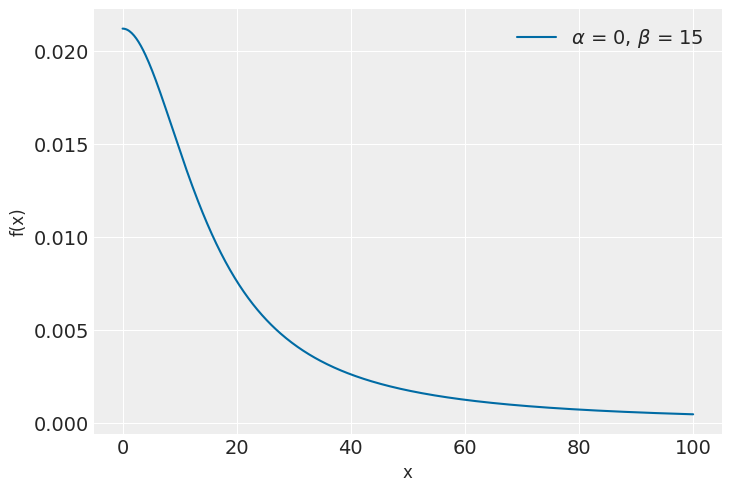

In [41]:
import scipy.stats as st

x = np.linspace(0, 100, 500)
alpha = 0
beta = 15
pdf = st.cauchy.pdf(x, loc=alpha, scale=beta)
plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(alpha, beta))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()


In questo secondo caso, più realistico, il modello diventa il seguente.

$$
\begin{align}
Y_i &\sim \mathcal{N}(\mu, \sigma) \notag\\
\mu &\sim \mathcal{N}(25, 2) \notag\\
\sigma &\sim Cauchy(0, 15) \notag
\end{align}
$$

Il modello precedente è simile a quello esaminato in precedenza, eccetto che abbiamo quantificato la nostra incertezza relativa a $\sigma$ (che è ignota) mediante una distribuzione a priori $Cauchy(0, 15)$.

Il campionamento MCMC utilizzato di default da PyMC è basata su un algoritmo sofisticato, detto NUTS (una variante del metodo Hybrid/Hamiltonian Monte Carlo che evita ulteriormente ripetizioni da parte della catena, calcolando in maniera adattiva il tempo delle traiettorie), il quale non richiede l'uso di distribuzioni a priori coniugate. Pertanto è possibile scegliere per i parametri una qualunque distribuzione a priori. Nel caso presente scelgo per $\sigma$ una $Cauchy(0, 15)$. Per un tale caso non è possibile ottenere la derivazione analitica della distribuzione a posteriori di $\mu$. È dunque necessario procedere con il campionamento MCMC.

Scrivo il modello in PyMC.

In [42]:
gauss2_model = pm.Model()

with gauss2_model:

    # Priors 
    mu = pm.Normal("mu", mu=25, sigma=2)
    sigma = pm.Cauchy("sigma", alpha=0, beta=15)
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y)

In [43]:
with gauss2_model:
    # draw 1000 posterior samples
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


Una sintesi della distribuzione a posteriori dei parametri si ottiene nel modo seguente.

In [44]:
az.summary(idata, round_to=2)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,29.21,1.17,27.06,31.40,0.03,0.02,2044.34,2356.70,1.0
sigma,7.06,1.01,5.31,8.96,0.02,0.02,2397.96,2083.34,1.0


Trovo l'intervallo di credibilità a più alta densità a posteriori (HPD) al 95%.


In [45]:
az.hdi(idata, hdi_prob=0.95)

<xarray.Dataset>
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 'lower' 'higher'
Data variables:
    mu       (hdi) float64 26.87 31.4
    sigma    (hdi) float64 5.291 9.108

Descrivo la traccia con un *trace plot* .


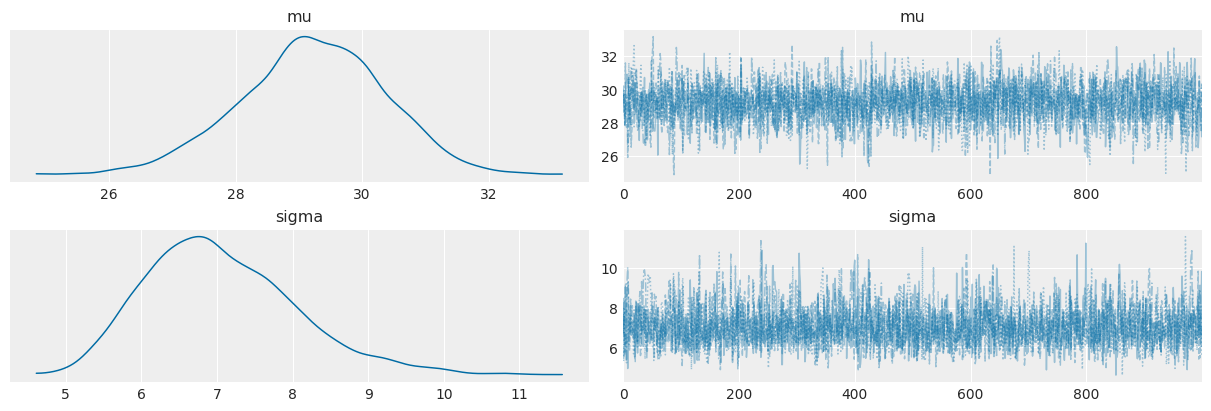

In [46]:
az.plot_trace(idata, combined=True)
plt.show()

Considerati i dati osservati e le mie ipotesi a priori sui parametri, posso dunque concludere, con un grado di certezza soggettiva del 95%, che la media della popolazione dei punteggi BDI-II dei pazienti clinici depressi è compresa nell'intervallo \[27.04, 31.33\].

## Commenti e considerazioni finali

In questo capitolo abbiamo visto come calcolare l'intervallo di credibilità per la media di una v.c. Normale. La domanda più ovvia di analisi dei dati, dopo avere visto come trovare l'intervallo di credibilità per la media di un solo gruppo, riguarda il confronto tra le medie di due gruppi. Il confronto tra le medie di due gruppi può essere considerato come un caso particolare di un metodo più generale di analisi dei dati, chiamato analisi di regressione lineare. Prima di discutere il problema del confronto tra le medie di due gruppi è dunque necessario esaminare il modello statistico della regressione lineare.

In [47]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Mon Dec 26 2022

Python implementation: CPython
Python version       : 3.8.15
IPython version      : 8.7.0

pytensor: 2.8.10

sys       : 3.8.15 (default, Nov 24 2022, 09:04:07) 
[Clang 14.0.6 ]
scipy     : 1.9.3
pymc      : 5.0.0
numpy     : 1.24.0
matplotlib: 3.6.2
arviz     : 0.14.0
pandas    : 1.5.2

Watermark: 2.3.1

